# Connexion du colab avec le drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Préparation du jeu de données

### 1- Extraction du fichier zip

In [2]:
import os
import zipfile

# Chemin du fichier ZIP sur Google Drive
zip_path = "/content/drive/MyDrive/malaria_hematie_dataset.zip"
extract_path = "/content/data"

# Extraction de l'archive ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Ajustement du chemin pour pointer sur le dossier extrait
data_path = os.path.join(extract_path, "malaria_hematie_dataset")
print("Extraction terminée.")
print("Contenu du dossier extrait :", os.listdir(data_path))

Extraction terminée.
Contenu du dossier extrait : ['parasitized', 'uninfected']


### 2- Réorganisation des données : séparation en ensembles d'entraînement, validation et test

In [3]:
import os
import shutil
import random

# Définition des chemins des répertoires
# Répertoire source contenant les images extraites
source_dir = data_path  # "/content/data/malaria_hematie_dataset"

# Répertoire cible où les données seront réorganisées en train, validation et test
base_dir_new = "/content/data/malaria_hematie_dataset_split"
os.makedirs(base_dir_new, exist_ok=True)  # Création du répertoire cible s'il n'existe pas

# Création de la structure des sous-dossiers
# Chaque ensemble (train, validation, test) contiendra deux catégories : "parasitized" et "uninfected"
for subset in ['train', 'validation', 'test']:
    for category in ["parasitized", "uninfected"]:
        os.makedirs(os.path.join(base_dir_new, subset, category), exist_ok=True)

# Définition des ratios de séparation des données
# - 70% des images seront utilisées pour l'entraînement
# - 15% pour la validation
# - 15% pour le test
split_ratios = [0.70, 0.15, 0.15]

# Fixation d'une seed pour garantir la reproductibilité du mélange aléatoire des fichiers
random.seed(42)

# Répartition des images dans les ensembles train, validation et test
for category in ["parasitized", "uninfected"]:
    category_dir = os.path.join(source_dir, category)  # Chemin du dossier contenant les images de la catégorie
    files = os.listdir(category_dir)  # Liste des fichiers (images) dans la catégorie
    random.shuffle(files)  # Mélanger les fichiers de manière réplicable grâce à la seed

    n = len(files)  # Nombre total d'images dans cette catégorie
    n_train = int(split_ratios[0] * n)  # Nombre d'images pour l'entraînement
    n_val = int(split_ratios[1] * n)    # Nombre d'images pour la validation

    # Séparation des fichiers en trois ensembles
    train_files = files[:n_train]
    val_files = files[n_train:n_train + n_val]
    test_files = files[n_train + n_val:]

    # Copie des fichiers dans leurs répertoires respectifs
    for f in train_files:
        src = os.path.join(category_dir, f)
        dst = os.path.join(base_dir_new, "train", category, f)
        shutil.copy(src, dst)  # Copie du fichier

    for f in val_files:
        src = os.path.join(category_dir, f)
        dst = os.path.join(base_dir_new, "validation", category, f)
        shutil.copy(src, dst)

    for f in test_files:
        src = os.path.join(category_dir, f)
        dst = os.path.join(base_dir_new, "test", category, f)
        shutil.copy(src, dst)

print("Réorganisation des données terminée avec seed=42.")  # Message de confirmation


Réorganisation des données terminée avec seed=42.


### 3- Préparation des générateurs de données et normalisation

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Chemins des ensembles réorganisés
train_dir = os.path.join(base_dir_new, "train")
validation_dir = os.path.join(base_dir_new, "validation")
test_dir = os.path.join(base_dir_new, "test")

# Générateur pour l'entraînement avec data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

# Générateur pour validation et test (uniquement normalisation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Paramètres
batch_size = 32
img_size = (128, 128)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',  # Labels binaires (0 ou 1)
    shuffle=True,
    seed=42
)

validation_generator = val_test_datagen.flow_from_directory(
    validation_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

print("Générateurs créés avec succès !")




Found 19290 images belonging to 2 classes.
Found 4132 images belonging to 2 classes.
Found 4136 images belonging to 2 classes.
Générateurs créés avec succès !


### 4- Visualisation des images transformées et augmentées

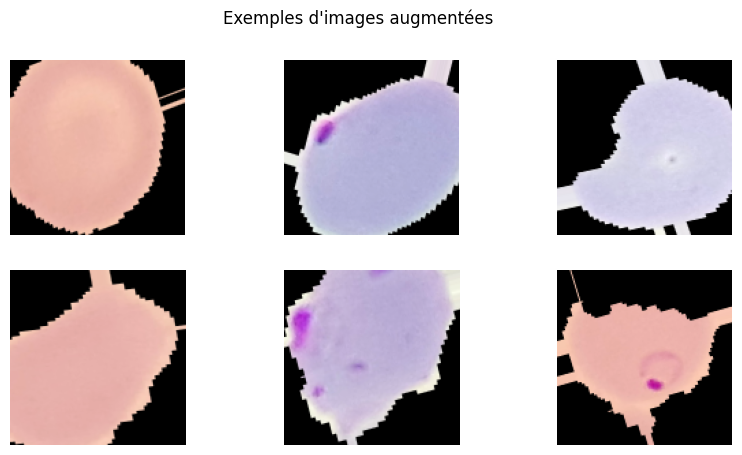

In [5]:
import matplotlib.pyplot as plt

augmented_images, augmented_labels = next(train_generator)

plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis("off")
plt.suptitle("Exemples d'images augmentées")
plt.show()

# Implémentation de 3 modèles de CNN

## Modèle from scratch

In [6]:
import keras
from tensorflow.keras import layers
model_scratch = keras.Sequential([
    # Bloc de convolution 1
    layers.Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(img_size[0], img_size[1], 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Bloc de convolution 2
    layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Dropout(0.3),
    layers.Flatten(),

    # Nouvelle architecture dense : 256 neurones puis 128 neurones
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(),

    # Couche de sortie pour la classification binaire
    layers.Dense(1, activation="sigmoid")
])
model_scratch.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      16,777,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,831,809 (64.21 MB)

 Trainable params: 16,830,849 (64.20 MB)

 Non-trainable params: 960 (3.75 KB)

## Fine-tuning du VGG16 pré-entraîné sur ImageNet

In [7]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization

# Charger le modèle VGG16 avec les poids d'ImageNet, sans la couche de classification finale
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Geler les premières couches du modèle et dégeler les dernières pour le fine-tuning
for layer in base_model_vgg16.layers[:-10]:
    layer.trainable = False
for layer in base_model_vgg16.layers[-10:]:
    layer.trainable = True

# Ajouter de nouvelles couches de classification
x = base_model_vgg16.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)  # Dropout dans l’encodeur
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(1, activation='sigmoid')(x)

# Créer le modèle complet
model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=predictions)
model_vgg16.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │              

 Total params: 15,145,281 (57.77 MB)

 Trainable params: 13,998,081 (53.40 MB)

 Non-trainable params: 1,147,200 (4.38 MB)

## Fine-tuning du ResNet50 pré-entraîné sur ImageNet

In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

# Définir l'entrée du modèle et appliquer preprocess_input
input_tensor = Input(shape=(img_size[0], img_size[1], 3))
preprocessed_input = preprocess_input(input_tensor)

# Charger ResNet50 avec les poids d'ImageNet, sans la couche de classification finale
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_tensor=preprocessed_input)

# Geler les premières couches du modèle et dégeler les dernières pour le fine-tuning
for layer in base_model_resnet.layers[:-10]:
    layer.trainable = False
for layer in base_model_resnet.layers[-10:]:
    layer.trainable = True

# Ajouter les nouvelles couches de classification
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)

# Dropout dans l'encodeur pour la régularisation
x = Dropout(0.2)(x)

# Couches denses pour la classification
x = Dense(1000, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(1, activation='sigmoid')(x)

# Créer le modèle complet
model_resnet50 = Model(inputs=input_tensor, outputs=predictions)


# Résumé du modèle
model_resnet50.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 128, 128)       │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 128, 128)       │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 128, 128)       │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 128, 128, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 128, 128, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)             

 Total params: 26,552,585 (101.29 MB)

 Trainable params: 7,425,977 (28.33 MB)

 Non-trainable params: 19,126,608 (72.96 MB)

## Configuration de l'entraînement du modèle avec des callbacks

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Définir les callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)

def train_model(model, train_gen, val_gen, epochs=150):
    # Compilation du modèle avec l'optimiseur Adam et un taux d'apprentissage à 0.0001
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    # Entraînement du modèle avec les callbacks configurés
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[early_stopping, reduce_lr],  # Les callbacks sont passés ici
        verbose=1  # Affichage de la progression
    )

    return history

In [10]:
history_scratch = train_model(model_scratch, train_generator, validation_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/150
603/603 ━━━━━━━━━━━━━━━━━━━━ 117s 175ms/step - accuracy: 0.6715 - loss: 0.6458 - val_accuracy: 0.7948 - val_loss: 0.4488 - learning_rate: 1.0000e-04
Epoch 2/150
603/603 ━━━━━━━━━━━━━━━━━━━━ 97s 160ms/step - accuracy: 0.8443 - loss: 0.3633 - val_accuracy: 0.9170 - val_loss: 0.2370 - learning_rate: 1.0000e-04
Epoch 3/150
603/603 ━━━━━━━━━━━━━━━━━━━━ 97s 161ms/step - accuracy: 0.8865 - loss: 0.2849 - val_accuracy: 0.9129 - val_loss: 0.2257 - learning_rate: 1.0000e-04
Epoch 4/150
603/603 ━━━━━━━━━━━━━━━━━━━━ 97s 160ms/step - accuracy: 0.9011 - loss: 0.2595 - val_accuracy: 0.9204 - val_loss: 0.2014 - learning_rate: 1.0000e-04
Epoch 5/150
603/603 ━━━━━━━━━━━━━━━━━━━━ 97s 161ms/step - accuracy: 0.9073 - loss: 0.2442 - val_accuracy: 0.9395 - val_loss: 0.1702 - learning_rate: 1.0000e-04
Epoch 6/150
603/603 ━━━━━━━━━━━━━━━━━━━━ 100s 166ms/step - accuracy: 0.9089 - loss: 0.2367 - val_accuracy: 0.9380 - val_loss: 0.1696 - learning_rate: 1.0000e-04
Epoch 7/150
603/603 ━━━━━━━━━━━━━━━━━━

In [11]:
history_vgg16 = train_model(model_vgg16, train_generator, validation_generator)

Epoch 1/150
603/603 ━━━━━━━━━━━━━━━━━━━━ 163s 243ms/step - accuracy: 0.8872 - loss: 0.2846 - val_accuracy: 0.9535 - val_loss: 0.1849 - learning_rate: 1.0000e-04
Epoch 2/150
603/603 ━━━━━━━━━━━━━━━━━━━━ 122s 202ms/step - accuracy: 0.9439 - loss: 0.1722 - val_accuracy: 0.9593 - val_loss: 0.1428 - learning_rate: 1.0000e-04
Epoch 3/150
603/603 ━━━━━━━━━━━━━━━━━━━━ 123s 204ms/step - accuracy: 0.9470 - loss: 0.1530 - val_accuracy: 0.9615 - val_loss: 0.1209 - learning_rate: 1.0000e-04
Epoch 4/150
603/603 ━━━━━━━━━━━━━━━━━━━━ 141s 203ms/step - accuracy: 0.9482 - loss: 0.1523 - val_accuracy: 0.9552 - val_loss: 0.2029 - learning_rate: 1.0000e-04
Epoch 5/150
603/603 ━━━━━━━━━━━━━━━━━━━━ 122s 202ms/step - accuracy: 0.9506 - loss: 0.1489 - val_accuracy: 0.9618 - val_loss: 0.1456 - learning_rate: 1.0000e-04
Epoch 6/150
603/603 ━━━━━━━━━━━━━━━━━━━━ 121s 201ms/step - accuracy: 0.9526 - loss: 0.1510 - val_accuracy: 0.5000 - val_loss: 3.0553 - learning_rate: 1.0000e-04
Epoch 7/150
603/603 ━━━━━━━━━━━━━━

In [12]:
history_resnet50 = train_model(model_resnet50, train_generator, validation_generator)

Epoch 1/150
603/603 ━━━━━━━━━━━━━━━━━━━━ 145s 208ms/step - accuracy: 0.5832 - loss: 0.7364 - val_accuracy: 0.6561 - val_loss: 0.6483 - learning_rate: 1.0000e-04
Epoch 2/150
603/603 ━━━━━━━━━━━━━━━━━━━━ 111s 184ms/step - accuracy: 0.6535 - loss: 0.6382 - val_accuracy: 0.6544 - val_loss: 0.7010 - learning_rate: 1.0000e-04
Epoch 3/150
603/603 ━━━━━━━━━━━━━━━━━━━━ 110s 183ms/step - accuracy: 0.6970 - loss: 0.5808 - val_accuracy: 0.7674 - val_loss: 0.4907 - learning_rate: 1.0000e-04
Epoch 4/150
603/603 ━━━━━━━━━━━━━━━━━━━━ 111s 184ms/step - accuracy: 0.7112 - loss: 0.5633 - val_accuracy: 0.7091 - val_loss: 0.5968 - learning_rate: 1.0000e-04
Epoch 5/150
603/603 ━━━━━━━━━━━━━━━━━━━━ 116s 192ms/step - accuracy: 0.7294 - loss: 0.5415 - val_accuracy: 0.7619 - val_loss: 0.5268 - learning_rate: 1.0000e-04
Epoch 6/150
603/603 ━━━━━━━━━━━━━━━━━━━━ 111s 184ms/step - accuracy: 0.7371 - loss: 0.5276 - val_accuracy: 0.7587 - val_loss: 0.5002 - learning_rate: 1.0000e-04
Epoch 7/150
603/603 ━━━━━━━━━━━━━━

## Visualisation des performances du modèle pendant l'entraînement

In [13]:
import matplotlib.pyplot as plt

def plot_training_history(history, model_name="Model"):
    plt.figure(figsize=(12, 5))

    # Courbe de la Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Loss Entrainement")
    plt.plot(history.history["val_loss"], label="Loss Validation")
    plt.title(f"Loss - {model_name}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Courbe de l'Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="Accuracy Entrainement")
    plt.plot(history.history["val_accuracy"], label="Accuracy Validation")
    plt.title(f"Accuracy - {model_name}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

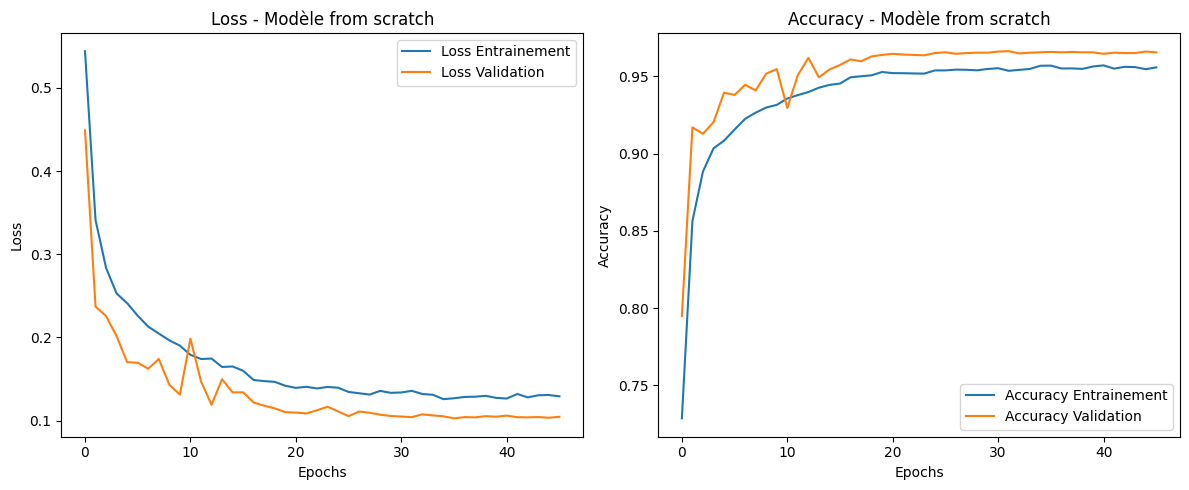

In [14]:
plot_training_history(history_scratch, model_name="Modèle from scratch")

## Évaluation des performances du modèle sur l'ensemble de test

In [17]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model_performance(model, test_gen, model_name="Model"):
    test_steps = test_gen.n // test_gen.batch_size
    y_pred_prob = model.predict(test_gen, steps=test_steps + 1)
    y_prob = y_pred_prob.flatten()
    y_true = test_gen.classes[:len(y_prob)]  # Vraies étiquettes

    # Calcul du ROC curve et de l’AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    print(f"AUC for {model_name}: {roc_auc:.4f}")

    # Déterminer le meilleur seuil (indice de Youden)
    youdens_index = tpr - fpr
    best_threshold = thresholds[np.argmax(youdens_index)]
    print(f"Best threshold for {model_name}: {best_threshold:.4f}")

    # Tracer la courbe ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {model_name}")
    plt.legend(loc="lower right")
    plt.show()

    # Prédictions basées sur le meilleur seuil
    y_pred = (y_prob > best_threshold).astype(int)

    #  Matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    print(f"Confusion Matrix for {model_name}:")
    print(cm)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Infecté", "Sain"], yticklabels=["Infecté", "Sain"])
    plt.xlabel("Prédictions")
    plt.ylabel("Vraies valeurs")
    plt.title(f"Matrice de Confusion pour {model_name}")
    plt.show()

    #  Rapport de classification et autres métriques
    report = classification_report(y_true, y_pred, target_names=["Infecté", "Sain"])
    print(f"Classification Report for {model_name}:\n{report}")

    # Calcul manuel des métriques pour plus de clarté
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Sensibilité (Recall) et Spécificité
    sensitivity = recall  # Sensibilité = rappel
    specificity = cm[0,0] / (cm[0,0] + cm[0,1])  # Spécificité = TN / (TN + FP)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensibilité): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1-Score: {f1:.4f}")

    return best_threshold


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step
AUC for Modèle from scratch: 0.9908
Best threshold for Modèle from scratch: 0.5432


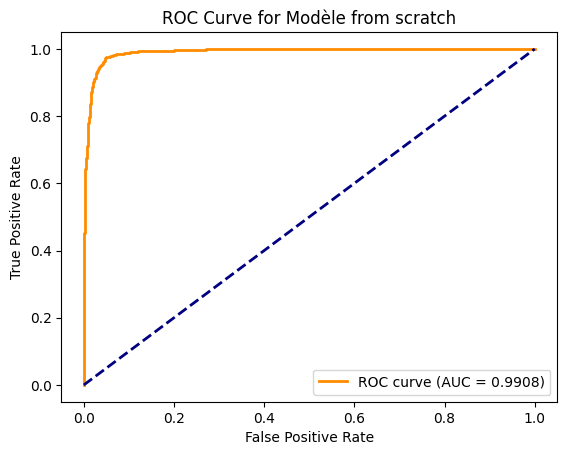

Confusion Matrix for Modèle from scratch:
[[1964  104]
 [  52 2016]]


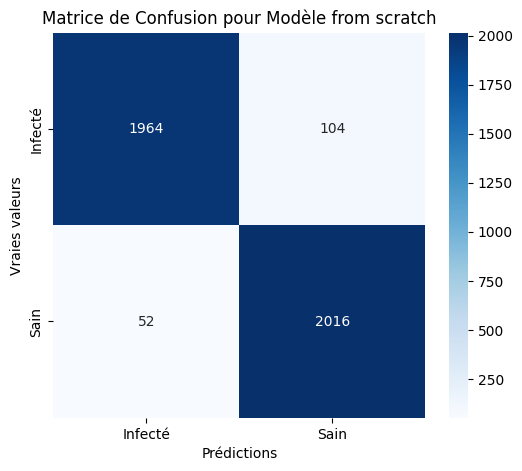

Classification Report for Modèle from scratch:
              precision    recall  f1-score   support

     Infecté       0.97      0.95      0.96      2068
        Sain       0.95      0.97      0.96      2068

    accuracy                           0.96      4136
   macro avg       0.96      0.96      0.96      4136
weighted avg       0.96      0.96      0.96      4136

Accuracy: 0.9623
Precision: 0.9509
Recall (Sensibilité): 0.9749
Specificity: 0.9497
F1-Score: 0.9628


In [18]:

best_thresh_scratch = evaluate_model_performance(model_scratch, test_generator, model_name="Modèle from scratch")

130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step
AUC for Modèle VGG16: 0.9931
Best threshold for Modèle VGG16: 0.5758


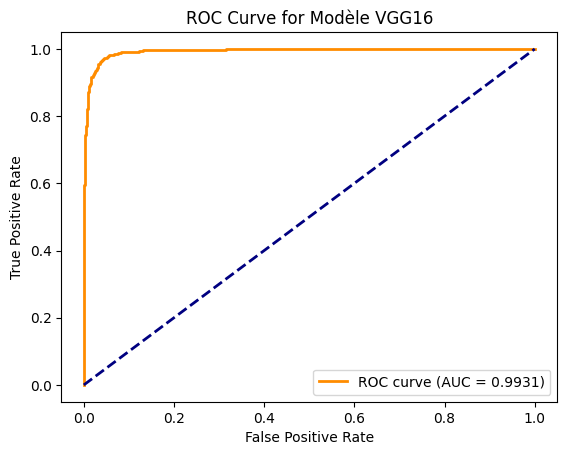

Confusion Matrix for Modèle VGG16:
[[1980   88]
 [  63 2005]]


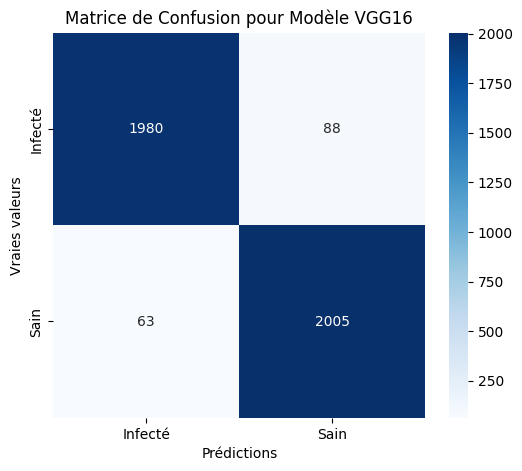

Classification Report for Modèle VGG16:
              precision    recall  f1-score   support

     Infecté       0.97      0.96      0.96      2068
        Sain       0.96      0.97      0.96      2068

    accuracy                           0.96      4136
   macro avg       0.96      0.96      0.96      4136
weighted avg       0.96      0.96      0.96      4136

Accuracy: 0.9635
Precision: 0.9580
Recall (Sensibilité): 0.9695
Specificity: 0.9574
F1-Score: 0.9637


In [19]:

best_thresh_vgg16 = evaluate_model_performance(model_vgg16, test_generator, model_name="Modèle VGG16")


130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step
AUC for Modèle ResNet50: 0.9070
Best threshold for Modèle ResNet50: 0.5036


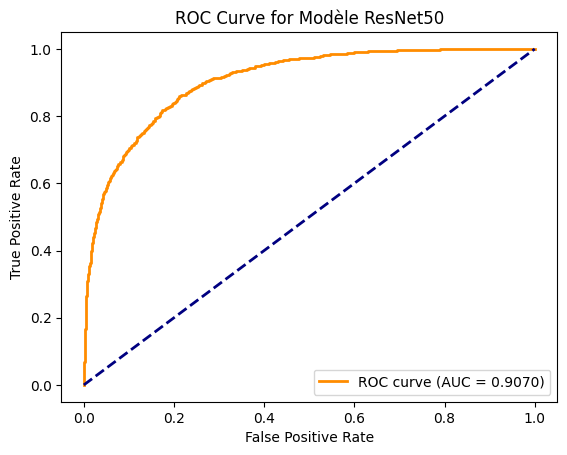

Confusion Matrix for Modèle ResNet50:
[[1629  439]
 [ 289 1779]]


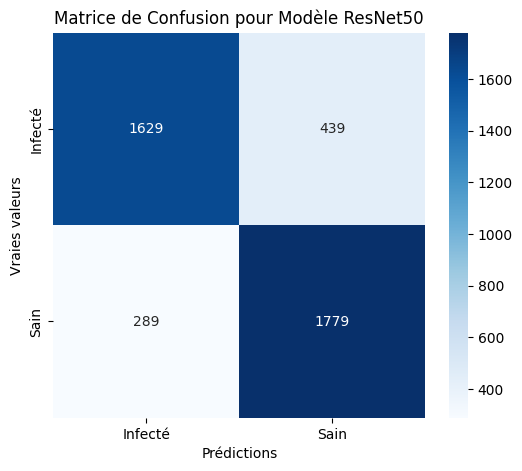

Classification Report for Modèle ResNet50:
              precision    recall  f1-score   support

     Infecté       0.85      0.79      0.82      2068
        Sain       0.80      0.86      0.83      2068

    accuracy                           0.82      4136
   macro avg       0.83      0.82      0.82      4136
weighted avg       0.83      0.82      0.82      4136

Accuracy: 0.8240
Precision: 0.8021
Recall (Sensibilité): 0.8603
Specificity: 0.7877
F1-Score: 0.8301


In [31]:
best_thresh_resnet50 = evaluate_model_performance(model_resnet50, test_generator, model_name="Modèle ResNet50")

## Prédiction sur une image individuelle

In [25]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def predict_image(model, image_path, best_threshold):
    # Chargement et prétraitement de l'image
    img = image.load_img(image_path, target_size=(img_size[0], img_size[1]))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalisation

    # Prédiction : sortie de forme (1, 1) avec sigmoid
    prediction = model.predict(img_array)
    prob = prediction[0][0]
    label = "Sain" if prob > best_threshold else "Infecté"

    print(f"Probabilité de 'Sain': {prob:.4f} (Best threshold: {best_threshold:.4f})")

    plt.imshow(img)
    plt.title(f"Prédiction : {label}")
    plt.axis("off")
    plt.show()

    return label

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Probabilité de 'Sain': 0.9887 (Best threshold: 0.5432)


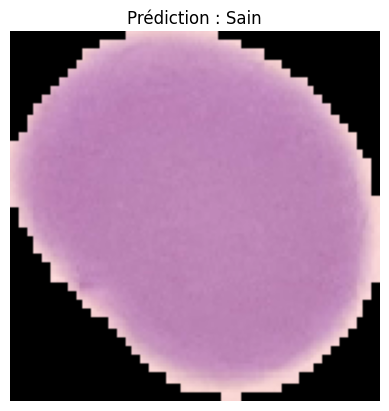

'Sain'

In [27]:
# Exemple de prédiction avec le modèle from scratch
predict_image(model_scratch, "/content/data/malaria_hematie_dataset_split/test/uninfected/image_10046.png", best_thresh_scratch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Probabilité de 'Sain': 0.9917 (Best threshold: 0.5758)


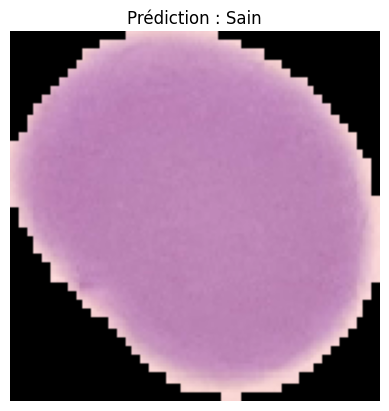

'Sain'

In [28]:
# Exemple de prédiction avec le modèle vgg16
predict_image(model_vgg16, "/content/data/malaria_hematie_dataset_split/test/uninfected/image_10046.png", best_thresh_vgg16)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Probabilité de 'Sain': 0.9747 (Best threshold: 0.5036)


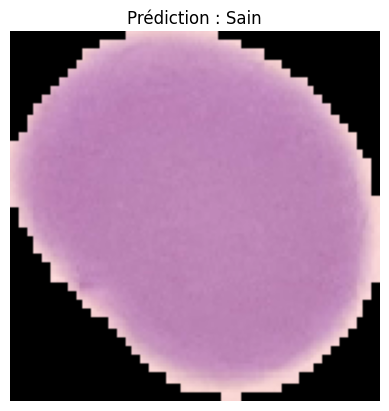

'Sain'

In [29]:
predict_image(model_resnet50, "/content/data/malaria_hematie_dataset_split/test/uninfected/image_10046.png", best_thresh_resnet50)

## Sauvegarde des poids des modèles entraînés

In [30]:
# Sauvegarder les poids du modèle from scratch
model_scratch.save_weights("model_scratch.weights.h5")

# Sauvegarder les poids du modèle VGG16
model_vgg16.save_weights("model_vgg16.weights.h5")

# Sauvegarder les poids du modèle ResNet50
model_resnet50.save_weights("model_resnet50.weights.h5")
